# Provisioning workers with SLURMCluster

We have a function called `whats_my_number` that takes a number as an argument and prints out what host the function is run on.

`report_results` appends the output from the various results and prints a report.

`elapsed` is a way of timing the execution (we could have used `%time` in this notebook, but we'll run similar code in a plain python script for comparison).

In [1]:
# -*- coding: utf-8 -*-
# from __future__ import absolute_import, division, print_function, unicode_literals

import re
import itertools
from collections import Counter

import time
import socket
import pendulum
import icecream
from tqdm import tqdm
from rich import print
from icecream import ic
from tqdm.notebook import trange, tqdm
from distributed.scheduler import logger

import numpy as np
import pandas as pd
import xarray as xr
import plotly.graph_objects as go
import plotly.express as px

import pronto
import networkx as nx
from nxontology import NXOntology
from nxontology.imports import (from_file, multidigraph_to_digraph,
                                pronto_to_multidigraph)
from networkx.drawing.nx_agraph import graphviz_layout
from nxontology.viz import create_similarity_graphviz

from dask import *
import dask.dataframe as dd
from dask.distributed import Client, progress, performance_report
from dask_jobqueue import SLURMCluster

# import gemo.config as config
# from gemo.data.network_similarity import KnowledgeGraphScores
# from gemo.features.build_features import filter_annotations, cook_dataset, batch_process

In [2]:
%load_ext rich

In [3]:
def whats_my_number(num):
    out ='The number on host ' + socket.gethostname() + ' is ' + str(num)
    time.sleep(2)
    return out

def report_results(results):
    out = 'Joining on host ' + socket.gethostname() + '\n'
    out += '\n'.join(results)
    return out

# How many seconds since start?
def elapsed(start):
    return str(time.time() - start) + ' seconds'

In [4]:
# Create the task graph
# 8 delayed calls to what's my number,
# Assemble output report

data = [1, 2, 3, 4, 5, 6, 7, 8]
results = []
for num in data:
    out = delayed(whats_my_number)(num)
    results.append(out)

report = delayed(report_results)(results)

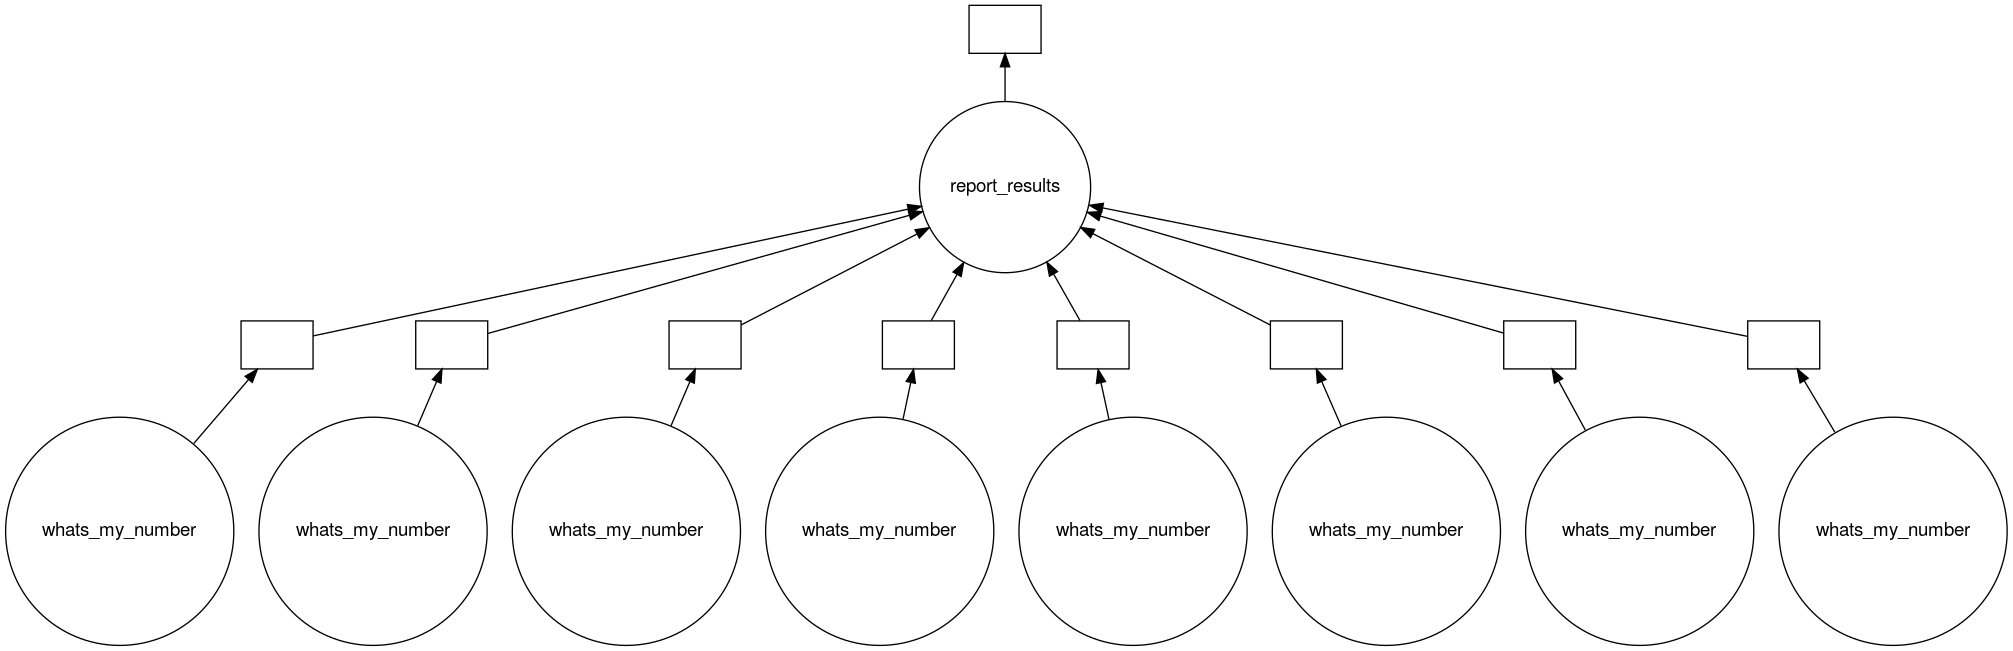

In [5]:
# Visualize the task graph
report.visualize()

## Create a 'SLURM Cluster' of workers and view dashboard

Note that no workers get provisioned yet

In [5]:
cluster = SLURMCluster(cores=4,
                       processes=1,
                       memory="1GB",
                       account="def-mtarailo_cpu",
                       walltime="00:10:00")
client = Client(cluster)
cluster

[09/25/23 19:19:22] INFO     State start                                                          ]8;id=601533;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=240317;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#1615\1615]8;;\

                    INFO       Scheduler at:   tcp://10.29.84.60:37787                            ]8;id=8950;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=19284;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#3860\3860]8;;\

                    INFO       dashboard at:                     :8787                            ]8;id=984034;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=175864;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#3862\3862]8;;\

                    INFO     Receive client connection:                                           ]8;id=529140;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=750202;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#5228\5228]8;;\
                             Client-f5f15f8e-5bf9-11ee-94d7-707990596056                                           

                    INFO     Starting established connection to tcp://10.29.84.60:58076                 ]8;id=923188;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=191422;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#867\867]8;;\

## We can check out the job submission script that will get sent to SLURM to provision each worker (one job per worker)

In [7]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A def-mtarailo_cpu
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=954M
#SBATCH -t 00:10:00

/home/rahit/jupyter_py3/bin/python -m distributed.cli.dask_worker tcp://10.29.84.158:35928 --nthreads 4 
--memory-limit 0.93GiB --name dummy-name --nanny --death-timeout 60

## Provision a worker and check the SLURM queue

In [6]:
cluster.scale(1)

In [11]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
         11478827    rahit     def-mtarailo_cpu    dask-worker   R       9:59     1    4        N/A    954M gra587 (Prolog) 
         11478564    rahit     def-mtarailo_cpu    interactive   R    5:56:40     1    1        N/A     16G gra699 (None) 


## Run our task graph on one worker

In [14]:
time1 = time.time()
result = report.compute()cc
print('Result computed:', elapsed(time1))
print('\nOutput:')
print(result)

Result computed: 4.588533401489258 seconds

Output:

Joining on host gra624
The number on host gra624 is 1
The number on host gra624 is 2
The number on host gra624 is 3
The number on host gra624 is 4
The number on host gra624 is 5
The number on host gra624 is 6
The number on host gra624 is 7
The number on host gra624 is 8

In [12]:
time1 = time.time()
result = report.compute()
print('Result computed:', elapsed(time1))
print('\nOutput:')
print(result)

Result computed: 6.6749587059021 seconds

Output:

Joining on host gra587
The number on host gra587 is 1
The number on host gra587 is 2
The number on host gra587 is 3
The number on host gra587 is 4
The number on host gra587 is 5
The number on host gra587 is 6
The number on host gra587 is 7
The number on host gra587 is 8

## Scale up to 4 workers and run again

In [13]:
cluster.scale(4)

In [28]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
         11478827    rahit     def-mtarailo_cpu    dask-worker   R       6:12     1    4        N/A    954M gra587 (None) 
         11479522    rahit     def-mtarailo_cpu    dask-worker   R       9:49     1    4        N/A    954M gra643 (None) 
         11479523    rahit     def-mtarailo_cpu    dask-worker   R       9:49     1    4        N/A    954M gra703 (None) 
         11479524    rahit     def-mtarailo_cpu    dask-worker   R       9:50     1    4        N/A    954M gra775 (None) 
         11478564    rahit     def-mtarailo_cpu    interactive   R    5:52:53     1    1        N/A     16G gra699 (None) 


In [30]:
time1 = time.time()
result = report.compute()
print('Result computed:', elapsed(time1))
print('\nOutput:')
print(result)

Result computed: 2.106113910675049 seconds

Output:

Joining on host gra643
The number on host gra643 is 1
The number on host gra643 is 2
The number on host gra775 is 3
The number on host gra703 is 4
The number on host gra587 is 5
The number on host gra775 is 6
The number on host gra703 is 7
The number on host gra587 is 8

## Scale up to 8 workers and run again

In [5]:
cluster.scale(4)

In [9]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
          2670269    rahit     def-mtarailo_cpu    interactive   R 3-09:38:01     1    1        N/A      8G gra92 (None) 


In [ ]:
time1 = time.time()
result = report.compute()
print('Result computed:', elapsed(time1))
print('\nOutput:')
print(result)

## Clean up the workers

In [31]:
# Shut down workers

cluster.close()
client.close()

[09/25/23 19:24:18] INFO     Connection to tcp://10.29.84.4:40462 has been closed.                      ]8;id=243268;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=872408;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#877\877]8;;\

                    INFO     Remove worker <WorkerState 'tcp://10.29.84.4:35654', name:           ]8;id=242567;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=402105;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#4795\4795]8;;\
                             SLURMCluster-1, status: running, memory: 0, processing: 0>                            

                    INFO     Removing comms to tcp://10.29.84.4:35654                                  ]8;id=346309;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=865312;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#1480\1480]8;;\

                    INFO     Connection to tcp://10.29.83.140:45038 has been closed.                    ]8;id=902594;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=773071;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#877\877]8;;\

                    INFO     Remove worker <WorkerState 'tcp://10.29.83.140:44919', name:         ]8;id=188182;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=665318;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#4795\4795]8;;\
                             SLURMCluster-0, status: running, memory: 0, processing: 0>                            

                    INFO     Removing comms to tcp://10.29.83.140:44919                                ]8;id=256421;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=630252;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#1480\1480]8;;\

                    INFO     Connection to tcp://10.29.84.64:37166 has been closed.                     ]8;id=418251;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=675468;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#877\877]8;;\

                    INFO     Remove worker <WorkerState 'tcp://10.29.84.64:40817', name:          ]8;id=174576;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=893453;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#4795\4795]8;;\
                             SLURMCluster-2, status: running, memory: 0, processing: 0>                            

                    INFO     Removing comms to tcp://10.29.84.64:40817                                 ]8;id=591297;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=862613;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#1480\1480]8;;\

                    INFO     Connection to tcp://10.29.84.136:48812 has been closed.                    ]8;id=927911;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=681342;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#877\877]8;;\

                    INFO     Remove worker <WorkerState 'tcp://10.29.84.136:33379', name:         ]8;id=777550;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=871929;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#4795\4795]8;;\
                             SLURMCluster-3, status: running, memory: 0, processing: 0>                            

                    INFO     Removing comms to tcp://10.29.84.136:33379                                ]8;id=820369;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=582244;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#1480\1480]8;;\

[09/25/23 19:24:19] INFO     Lost all workers                                                     ]8;id=980952;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=79560;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#4875\4875]8;;\

                    INFO     Scheduler closing...                                                 ]8;id=796137;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=597194;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#3925\3925]8;;\

                    INFO     Scheduler closing all comms                                          ]8;id=463646;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=72294;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#3947\3947]8;;\

In [32]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
         11478564    rahit     def-mtarailo_cpu    interactive   R    5:52:11     1    1        N/A     16G gra699 (None) 
